# <span style="color:#0b486b">  FIT3181: Deep Learning (2021)</span>
***
*CE/Lecturer:* Dr **Trung Le** | trunglm@monash.edu <br/>
*Head Tutor:* Mr **Thanh Nguyen** | thanh.nguyen4@monash.edu <br/>
<br/>
Department of Data Science and AI, Faculty of Information Technology, Monash University, Australia
***

# <span style="color:#0b486b">  Student Information</span>
Surname: **Haw**  <br/>
Firstname: **Xiao Ying**    <br/>
Student ID: **29797918**    <br/>
Email: **xhaw0001@student.monash.edu**    <br/>
Your tutorial time: **Tuesday 3pm-5pm**    <br/>
***

## <span style="color:#0b486b">Assignment 02: Neural Embedding and Sequence Modelling</span>
### Due: <span style="color:red">11:59pm 31 October 2021</span>  (Sunday)

#### <span style="color:red">Important note:</span> This is an **individual** assignment. It contributes **20%** to you final mark. Read the assignment instruction carefully.

## <span style="color:#0b486b">Instructions</span>

This notebook has been prepared for your to complete Assignment 2. The theme of this assignment is about practical machine learning knowledge and skills in deep neural networks, word embedding and text analytics. Some sections have been partially completed to help you get
started. **The total marks for this notebook is 100**.

* Before you start, read the entire notebook carefully once to understand what you need to do. <br><br>
* For each cell marked with **#YOU ARE REQUIRED TO INSERT YOUR CODES IN THIS CELL**, there will be places where you **must** supply your own codes when instructed. <br>

This assignment contains **four** parts:

* Part 1: Questions on downloading and preprocessing data **[10 points]**
* Part 2: Questions on using Word2Vect to transform texts to vectors **[20 points]**
* Part 3: Coding assessment on Text CNN for sequence modeling and neural embedding **[10 points]**
* Part 4: Coding assessment on RNNs for sequence modeling and neural embedding **[60 points]**


**Hint**: This assignment was essentially designed based on the lectures and tutorials sessions covered from Weeks 7 to 10. You are strongly recommended to go through these contents thoroughly which might help you to complete this assignment.

## <span style="color:#0b486b">What to submit</span>

This assignment is to be completed individually and submitted to Moodle unit site. **By the due date, you are required to submit one  <span style="color:red; font-weight:bold">single zip file, named xxx_assignment02_solution.zip</span> where `xxx` is your student ID, to the corresponding Assignment (Dropbox) in Moodle**. 

***For example, if your student ID is <span style="color:red; font-weight:bold">12356</span>, then gather all of your assignment solution to folder, create a zip file named <span style="color:red; font-weight:bold">123456_assignment02_solution.zip</span> and submit this file.***

Within this zip folder, you **must** submit the following files:
1.	**Assignment02_solution.ipynb**:  this is your Python notebook solution source file.
1.	**Assignment02_output.html**: this is the output of your Python notebook solution *exported* in html format.
1.	Any **extra files or folder** needed to complete your assignment (e.g., images used in your answers).

## <span style="color:#0b486b">Set random seeds</span>

We start with importing tensorflow and numpy and setting random seeds for TF and numpy. You can use any seeds you prefer.

In [1]:
import numpy as np
import tensorflow as tf

tf.random.set_seed(6789)
np.random.seed(6789)

## <span style="color:#0b486b">Part 1: Download and preprocess the data</span>

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 10 points]<span></div>

The dataset we use for this assignment is a question classification dataset for which the train set consists of $500$ questions belonging to 6 coarse question categories including:
- abbreviation (ABBR), 
- entity (ENTY), 
- description (DESC), 
- human (HUM), 
- location (LOC) and 
- numeric (NUM).


Preprocessing data is an inital and important step in any machine learning or deep learning projects. The following *DataManager* class helps you to download data and preprocess data for the later steps of a deep learning project. 

In [2]:
import os
import zipfile
import collections
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.style.use('ggplot')

class DataManager:
    def __init__(self, verbose=True, maxlen= 50, random_state=6789):
        self.verbose = verbose
        self.max_sentence_len = 0
        self.str_questions = list()
        self.str_labels = list()
        self.numeral_labels = list()
        self.maxlen = maxlen
        self.numeral_data = list()
        self.random_state = random_state
        self.random = np.random.RandomState(random_state)
        
    @staticmethod
    def maybe_download(dir_name, file_name, url, verbose= True):
        if not os.path.exists(dir_name):
            os.mkdir(dir_name)
        if not os.path.exists(os.path.join(dir_name, file_name)):
            urlretrieve(url + file_name, os.path.join(dir_name, file_name))
        if verbose:
            print("Downloaded successfully {}".format(file_name))
    
    def read_data(self, dir_name, file_names):
        for file_name in file_names:
            file_path= os.path.join(dir_name, file_name)
            self.str_questions= list(); self.str_labels= list()
            with open(file_path, "r", encoding="latin-1") as f:
                for row in f:
                    row_str= row.split(":")
                    label, question= row_str[0], row_str[1]
                    question= question.lower()
                    self.str_labels.append(label)
                    self.str_questions.append(question[0:-1])
                    if self.max_sentence_len < len(self.str_questions[-1]):
                        self.max_sentence_len= len(self.str_questions[-1])
         
        # turns labels into numbers
        le= preprocessing.LabelEncoder()
        le.fit(self.str_labels)
        self.numeral_labels = np.array(le.transform(self.str_labels))
        self.str_classes= le.classes_
        self.num_classes= len(self.str_classes)
        if self.verbose:
            print("\nSample questions... \n")
            print(self.str_questions[0:5])
            print("Labels {}\n\n".format(self.str_classes))
    
    def manipulate_data(self):
        tokenizer = tf.keras.preprocessing.text.Tokenizer()
        tokenizer.fit_on_texts(self.str_questions)
        self.numeral_data = tokenizer.texts_to_sequences(self.str_questions)
        self.numeral_data = tf.keras.preprocessing.sequence.pad_sequences(self.numeral_data, padding='post', truncating= 'post', maxlen= self.maxlen)
        self.word2idx = tokenizer.word_index
        self.word2idx = {k:v for k,v in self.word2idx.items()}
        self.idx2word = {v:k for k,v in self.word2idx.items()}
        self.vocab_size = len(self.word2idx)
    
    def train_valid_split(self, train_ratio=0.9):
        idxs = np.random.permutation(np.arange(len(self.str_questions)))
        train_size = int(train_ratio*len(idxs)) +1
        self.train_str_questions, self.valid_str_questions = self.str_questions[0:train_size], self.str_questions[train_size:]
        self.train_numeral_data, self.valid_numeral_data = self.numeral_data[0:train_size], self.numeral_data[train_size:]
        self.train_numeral_labels, self.valid_numeral_labels = self.numeral_labels[0:train_size], self.numeral_labels[train_size:]
        self.tf_train_set = tf.data.Dataset.from_tensor_slices((self.train_numeral_data, self.train_numeral_labels))
        self.tf_valid_set = tf.data.Dataset.from_tensor_slices((self.valid_numeral_data, self.valid_numeral_labels))

In [3]:
print('Loading data...')
DataManager.maybe_download("Data", "train_1000.label", "http://cogcomp.org/Data/QA/QC/")
DataManager.maybe_download("Data", "TREC_10.label", "http://cogcomp.org/Data/QA/QC/")

dm = DataManager(maxlen=100)
dm.read_data("Data/", ["train_1000.label", "TREC_10.label"])   # read data

Loading data...
Downloaded successfully train_1000.label
Downloaded successfully TREC_10.label

Sample questions... 

['dist how far is it from denver to aspen ?', 'city what county is modesto , california in ?', 'desc who was galileo ?', 'def what is an atom ?', 'date when did hawaii become a state ?']
Labels ['ABBR' 'DESC' 'ENTY' 'HUM' 'LOC' 'NUM']




In [4]:
dm.manipulate_data()
dm.train_valid_split(train_ratio=0.8)

You now have a data manager, named *dm* containing the training and validiation sets in both text and numeric forms. Your task is to play around and read this code to figure out the meanings of some important attributes that will be used in the next parts.

#### <span style="color:red">**Question 1.1**</span> 
**What is the purpose of `self.train_str_questions` and `self.train_numeral_labels`? Write your code to print out the first five questions with labels in the training set.**

<div style="text-align: right"><span style="color:red">[2 points]</span></div> 

`self.train_str_questions` is used to store the training set of questions and `self.train_numeral_labels` is used to store the  labels of the training set in the form of numeric numbers.

In [5]:
for i in range(5):
    q = dm.train_str_questions[i]
    l = dm.train_numeral_labels[i]
    print("Question", i+1, ":", q)
    print("Label", i+1, ":", l , "\n")

Question 1 : dist how far is it from denver to aspen ?
Label 1 : 5 

Question 2 : city what county is modesto , california in ?
Label 2 : 4 

Question 3 : desc who was galileo ?
Label 3 : 3 

Question 4 : def what is an atom ?
Label 4 : 1 

Question 5 : date when did hawaii become a state ?
Label 5 : 5 



#### <span style="color:red">**Question 1.2**</span> 
**What is the purpose of `self.train_numeral_data`? Write your code to print out the first five questions in the numeric format with labels in the training set.**

<div style="text-align: right"><span style="color:red">[2 points]</span></div> 

`self.train_numeral_data` is used to store the training set of questions in the form of list where there are only numbers representing the vector of the word. The maximum length of the sentence (list) is 100 words (vectors).

In [6]:
for i in range(5):
    q = dm.train_numeral_data[i]
    l = dm.train_numeral_labels[i]
    print("Question", i+1, ":", q)
    print("Label", i+1, ":", l , "\n")

Question 1 : [ 27  14  73   3 115  39 305  20 306   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]
Label 1 : 5 

Question 2 : [ 18   1 153   3 307 308   6   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]
Label 2 : 4 

Question 3 : [ 42  12   8 309   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0  

#### <span style="color:red">**Question 1.3**</span> 
**What is the purpose of two dictionaries: `self.word2idx` and `self.idx2word`? Write your code to print out the first five key-value pairs of those dictionaries.**

<div style="text-align: right"><span style="color:red">[2 points]</span></div> 

`self.word2idx` has the word as the key and the vector of the word as the value, so that we are able to obtain the vector by using the word as the key. <br/>
`self.idx2word` has the vector of the word as the key and the word as the value, so that we are able to obtain the word by using the vector as the key.

In [7]:
word2idx = list(dm.word2idx.items())[:5]
idx2word = list(dm.idx2word.items())[:5]
print('self.word2idx:', word2idx)
print('self.idx2word:', idx2word)

self.word2idx: [('what', 1), ('the', 2), ('is', 3), ('def', 4), ('of', 5)]
self.idx2word: [(1, 'what'), (2, 'the'), (3, 'is'), (4, 'def'), (5, 'of')]


#### <span style="color:red">**Question 1.4**</span> 
**What is the purpose of `self.tf_train_set`? Write your code to print out the first five items of `self.tf_train_set`.**

<div style="text-align: right"><span style="color:red">[2 points]</span></div> 

`self.tf_train_set` contains the training data in tensorflow variable. The numeral data and numeral label can be found in this training data.

In [8]:
count = 0

for x,y in dm.tf_train_set:
    print("Item",count+1,":\n",x,"\n",y,"\n")
    count += 1
    if count == 5:
        break

Item 1 :
 tf.Tensor(
[ 27  14  73   3 115  39 305  20 306   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0], shape=(100,), dtype=int32) 
 tf.Tensor(5, shape=(), dtype=int32) 

Item 2 :
 tf.Tensor(
[ 18   1 153   3 307 308   6   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0], shape=(100,), dtype=int32) 
 tf.Tensor(4, shape=(), dtype=int32) 

Item 3 :

#### <span style="color:red">**Question 1.5**</span> 
**What is the purpose of `self.tf_valid_set`? Write your code to print out the first five items of `self.tf_valid_set`.**

<div style="text-align: right"><span style="color:red">[2 points]</span></div> 

`self.tf_valid_set` contains the validation data in tensorflow variable. The numeral data and numeral label can be found in this validation data.

In [9]:
count = 0

for x,y in dm.tf_valid_set:
    print("Item",count+1,":\n",x,"\n",y,"\n")
    count += 1
    if count == 5:
        break

Item 1 :
 tf.Tensor(
[ 32   1   3   2 921 922 923 924   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0], shape=(100,), dtype=int32) 
 tf.Tensor(2, shape=(), dtype=int32) 

Item 2 :
 tf.Tensor(
[ 11  17   3 925  15  69   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0], shape=(100,), dtype=int32) 
 tf.Tensor(5, shape=(), dtype=int32) 

Item 3 :

## <span style="color:#0b486b">Part 2: Using Word2Vect to transform texts to vectors </span>

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 20 points]<span></div>

In this part, you will be assessed on how to use a pretrained Word2Vect model for realizing a machine learning task. Basically, you will use this pretrained Word2Vect to transform the questions in the above dataset stored in the *data manager object dm* to numeric form for training a Support Vector Machine in sckit-learn.  

In [10]:
import gensim.downloader as api
from gensim.models import Word2Vec
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

#### <span style="color:red">**Question 2.1**</span> 
**Write code to download the pretrained model *glove-wiki-gigaword-100*. Note that this model transforms a word in its dictionary to a $100$ dimensional vector.**

<div style="text-align: right"><span style="color:red">[2 points]</span></div> 

In [11]:
word2vect = api.load('glove-wiki-gigaword-100')

#### <span style="color:red">**Question 2.2**</span> 

**Write code for the function *get_word_vector(word, model)* used to transform a word to a vector using the pretrained Word2Vect model *model*. Note that for a word not in the vocabulary of our *word2vect*, you need to return a vector $0$ with 100 dimensions.**

<div style="text-align: right"><span style="color:red">[3 points]</span></div> 

In [12]:
def get_word_vector(word, model):
    try:
        vector = model.get_vector(word)
    except: #word not in the vocabulary
        vector = np.zeros(100)
    return vector

#### <span style="color:red">**Question 2.3**</span> 

**Write the code for the function `get_sentence_vector(sentence, important_score=None, model= None)`. Note that this function will transform a sentence to a 100-dimensional vector using the pretrained model *model*. In addition, the list *important_score* which has the same length as the *sentence* specifies the important scores of the words in the sentence. In your code, you first need to apply *softmax* function over *important_score* to obtain the important weight *important_weight* which forms a probability over the words of the sentence. Furthermore, the final vector of the sentence will be weighted sum of the individual vectors for words and the weights in *important_weight*.**
- $important\_weight = softmax(important\_score)$.
- $final\_vector= important\_weight[1]\times v[1] + important\_weight[2]\times v[2] + ...+ important\_weight[L]\times v[L]$ where $L$ is the length of the sentence and $v[i]$ is the vector representation of the $i-th$  word in this sentence.

**Note that if *important_score=None* is set by default, your function should return the average of all representation vectors corresponding to set *important_score=[1,1,...,1]*.**

<div style="text-align: right"><span style="color:red">[5 points]</span></div> 

In [13]:
def get_sentence_vector(sentence, important_score=None, model= None):
    
    tokens = sentence.split()
    vecs = [get_word_vector(word, model) for word in tokens if word in model]
    
    if important_score is None:
        important_score = np.ones(len(tokens))
        
    important_weight = np.zeros(len(important_score))
    total = np.sum(np.exp(important_score))
    for i in range(len(important_score)):
        current = np.exp(important_score[i])
        important_weight[i] = current/total
        
    final_vector = important_weight[0]*vecs[0]
    for k in range(1,len(vecs)):
        final_vector += important_weight[k]*vecs[k]
        
    return final_vector

#### <span style="color:red">**Question 2.4**</span> 

**Write code to transform the training questions in *dm.train_str_questions* to feature vectors. Note that after running the following cell, you must have $X\_train$ which is an numpy array of the feature vectors and $y\_train$ which is an array of numeric labels (*Hint: dm.train_numeral_labels*). You can add more lines to the following cell if necessary. In addition, you should decide the *important_score* by yourself. For example, you might reckon that the 1st score is 1, the 2nd score is decayed by 0.9, the 3rd is decayed by 0.9, and so on.**

<div style="text-align: right"><span style="color:red">[2 points]</span></div> 

In [14]:
print("Transform training set to feature vectors...")
X_train = []
y_train = dm.train_numeral_labels
for x in dm.train_str_questions:
    vec = get_sentence_vector(x, None, word2vect)
    X_train.append(vec)
X_train = np.array(X_train)

Transform training set to feature vectors...


#### <span style="color:red">**Question 2.5**</span> 

**Write code to transform the training questions in *dm.valid_str_questions* to feature vectors. Note that after running the following cell, you must have $X\_valid$ which is an numpy array of the feature vectors and $y\_valid$ which is an array of numeric labels (*Hint: dm.valid_numeral_labels*). You can add more lines to the following cell if necessary. In addition, you should decide the *important_score* by yourself. For example, you might reckon that the 1st score is 1, the 2nd score is decayed by 0.9, the 3rd is decayed by 0.9, and so on.**

<div style="text-align: right"><span style="color:red">[2 points]</span></div> 

In [15]:
print("Transform valid set to feature vectors...")
X_valid = []
y_valid = dm.valid_numeral_labels
for x in dm.valid_str_questions:
    vec = get_sentence_vector(x, None, word2vect)
    X_valid.append(vec)
X_valid = np.array(X_valid)

Transform valid set to feature vectors...


#### <span style="color:red">**Question 2.6**</span> 

**It is now to use *MinMaxScaler(feature_range=(-1,1))* in sckit-learn to scale both training and valid sets to the range $(-1,1)$.**

<div style="text-align: right"><span style="color:red">[2 points]</span></div> 

In [16]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(X_train)
X_train = scaler.transform(X_train)
scaler.fit(X_valid)
X_valid = scaler.transform(X_valid)

#### <span style="color:red">**Question 2.7**</span> 

**Declare a support vector machine (the class *SVC*  in sckit-learn) with RBF kernel, $C=1$, $gamma= 2^{-3}$ and fit on the training set.**

<div style="text-align: right"><span style="color:red">[2 points]</span></div> 

In [17]:
svm = SVC(kernel='rbf', C=1, gamma=0.002)
clf = svm.fit(X_train, y_train)

#### <span style="color:red">**Question 2.8**</span> 

**Finally, we use the trained *svm* to evaluate on the valid set $X\_valid$.**

<div style="text-align: right"><span style="color:red">[2 points]</span></div> 

In [18]:
y_valid_pred= svm.predict(X_valid)
acc = accuracy_score(y_valid, y_valid_pred)

print("Accuracy of trained svm on valid set:", acc)

Accuracy of trained svm on valid set: 0.43434343434343436


## <span style="color:#0b486b">Part 3: Text CNN for sequence modeling and neural embedding </span>

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 10 points]<span></div>

#### <span style="color:red">**Question 3.1**</span> 

**In what follows, you are required to complete the code for Text CNN for sentence classification. The paper of Text CNN can be found at this [link](https://www.aclweb.org/anthology/D14-1181.pdf). Here is the description of the Text CNN you need to construct.**
- There are three attributes (properties or instance variables): *embed_size, state_size, data_manager*.
  - `embed_size`: the dimension of the vector space for which the words are embedded to using the embedding matrix.
  - `state_size`: the number of filters used in *Conv1D* (reference [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D)).
  - `data_manager`: the data manager to store information of the dataset.
- The detail of the computational process is as follows:
  - Given input $x$, we embed $x$ using the embedding matrix to obtain an $3D$ tensor $[batch\_size \times vocab\_size \times embed\_size]$ as $h$.
  - We feed $h$ to three Convd 1D layers, each of which has $state\_size$ filters, padding=same, activation= relu, and $kernel\_size= 3, 5, 7$ respectively to obtain $h1, h2, h3$. Note that each $h1, h2, h3$ is a 3D tensor with the shape $[batch\_size \times output\_size \times state\_size]$.
  - We then apply *GlobalMaxPool1D()* (reference [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalMaxPool1D)) over $h1, h2, h3$ to obtain 2D tensors stored in $h1, h2, h3$ again.
  - We then concatenate three 2D tensors $h1, h2, h3$ to obtain $h$. Note that you need to specify the axis to concatenate.
  - We finally build up one dense layer on the top of $h$ for classification.
  
  <div style="text-align: right"><span style="color:red">[8 points]</span></div>
  

In [19]:
class TextCNN:
    def __init__(self, embed_size= 128, state_size=16, data_manager=None):
        self.data_manager = data_manager
        self.embed_size = embed_size
        self.state_size = state_size
    
    def build(self):
        x = tf.keras.layers.Input(shape=[None])
        h = tf.keras.layers.Embedding(self.data_manager.vocab_size +1, self.embed_size)(x)
        h1 = tf.keras.layers.Conv1D(filters=self.state_size, kernel_size=3, padding='same', activation='relu')(h)
        h2 = tf.keras.layers.Conv1D(filters=self.state_size, kernel_size=5, padding='same', activation='relu')(h)
        h3 = tf.keras.layers.Conv1D(filters=self.state_size, kernel_size=7, padding='same', activation='relu')(h)
        h1 = tf.keras.layers.GlobalMaxPool1D()(h1)
        h2 = tf.keras.layers.GlobalMaxPool1D()(h2)
        h3 = tf.keras.layers.GlobalMaxPool1D()(h3)
        h = tf.keras.layers.concatenate([h1, h2, h3], axis=1)
        h = tf.keras.layers.Dense(self.data_manager.num_classes, activation='softmax')(h)
        self.model = tf.keras.Model(inputs=x, outputs=h) 
    
    def compile_model(self, *args, **kwargs):
        self.model.compile(*args, **kwargs)
    
    def fit(self, *args, **kwargs):
        return self.model.fit(*args, **kwargs)
    
    def evaluate(self, *args, **kwargs):
        self.model.evaluate(*args, **kwargs)


#### <span style="color:red">**Question 3.2**</span> 
**Here is the code to test TextCNN above. You can observe that TextCNN outperforms the traditional approach SVM + Word2Vect for this task. The reason is that TextCNN enables us to automatically learn the feature that fits to the task. This makes deep learning different from hand-crafted feature approaches. Complete the code to test the model. Note that when compiling the model, you can use the Adam optimizer.**

<div style="text-align: right"><span style="color:red">[2 points]</span></div>

In [20]:
text_cnn = TextCNN(data_manager=dm)
text_cnn.build()
text_cnn.compile_model(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
text_cnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data = dm.tf_valid_set.batch(64))

Epoch 1/20
7/7 [==============================] - 2s 115ms/step - loss: 1.7450 - accuracy: 0.3965 - val_loss: 1.7266 - val_accuracy: 0.4242
Epoch 2/20
7/7 [==============================] - 0s 64ms/step - loss: 1.6031 - accuracy: 0.5810 - val_loss: 1.6472 - val_accuracy: 0.3939
Epoch 3/20
7/7 [==============================] - 0s 62ms/step - loss: 1.4762 - accuracy: 0.5411 - val_loss: 1.5596 - val_accuracy: 0.3939
Epoch 4/20
7/7 [==============================] - 0s 63ms/step - loss: 1.3451 - accuracy: 0.5711 - val_loss: 1.4568 - val_accuracy: 0.4040
Epoch 5/20
7/7 [==============================] - 0s 65ms/step - loss: 1.2052 - accuracy: 0.6534 - val_loss: 1.3325 - val_accuracy: 0.4747
Epoch 6/20
7/7 [==============================] - 0s 63ms/step - loss: 1.0545 - accuracy: 0.7082 - val_loss: 1.1905 - val_accuracy: 0.5455
Epoch 7/20
7/7 [==============================] - 0s 64ms/step - loss: 0.8995 - accuracy: 0.8105 - val_loss: 1.0475 - val_accuracy: 0.5960
Epoch 8/20
7/7 [==========

## <span style="color:#0b486b">Part 4: RNNs for sequence modeling and neural embedding </span>

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 60 points]<span></div>

### <span style="color:#0b486b">4.1. One-directional RNNs for sequence modeling and neural embedding </span> ###

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 10 points]<span></div>

#### <span style="color:red">**Question 4.1.1**</span> 
**In this part, you need to construct an RNN to learn from the dataset of interest. Basically, you are required first to construct the class UniRNN (Uni-directional RNN) with the following requirements:**
- Attribute `data_manager (self.data_manager)`: specifies the data manager used to store data for the model.
- Attribute `cell_type (self.cell_type)`: can receive three values including `basic_rnn`, `gru`, and `lstm` which specifies the memory cells formed a hidden layer.
- `state_sizes (self.state_sizes)` indicates the list of the hidden sizes  of memory cells. For example, $state\_sizes = [64, 128]$ means that you have two hidden layers in your network with hidden sizes of $64$ and $128$ respectively.

**Note that when declaring an embedding layer for the network, you need to set *mask_zero=True* so that the padding zeros in the sentences will be masked and ignored. This helps to have variable length RNNs. For more detail, you can refer to this [link](https://www.tensorflow.org/guide/keras/masking_and_padding).**

<div style="text-align: right"><span style="color:red">[7 points]</span></div>

In [21]:
class UniRNN:
    def __init__(self, cell_type= 'gru', embed_size= 128, state_sizes= [128, 64], data_manager= None):
        self.cell_type = cell_type
        self.state_sizes = state_sizes
        self.embed_size = embed_size
        self.data_manager = data_manager
        self.vocab_size = self.data_manager.vocab_size +1 
        
    #return the correspoding memory cell
    @staticmethod
    def get_layer(cell_type='gru', state_size= 128, return_sequences= False, activation = 'tanh'):
        if cell_type=='gru':
            return tf.keras.layers.GRU(units=state_size, activation=activation, return_sequences=return_sequences)
        elif cell_type== 'lstm':
            return tf.keras.layers.LSTM(units=state_size, activation=activation, return_sequences=return_sequences)
        else:
            return tf.keras.layers.SimpleRNN(units=state_size, activation=activation, return_sequences=return_sequences)
    
    def build(self):
        x = tf.keras.layers.Input(shape=[None])
        h = tf.keras.layers.Embedding(self.vocab_size, self.embed_size, mask_zero=True)(x)
        num_layers = len(self.state_sizes)
        for i in range(num_layers):
            h = self.get_layer(cell_type=self.cell_type, state_size=self.state_sizes[i], return_sequences=True)(h)
            if i == num_layers - 1:
                h = self.get_layer(cell_type=self.cell_type, state_size=self.state_sizes[i], return_sequences=False)(h)
        h = tf.keras.layers.Dense(dm.num_classes, activation='softmax')(h)
        self.model = tf.keras.Model(inputs=x, outputs=h)
   
    def compile_model(self, *args, **kwargs):
        self.model.compile(*args, **kwargs)
    
    def fit(self, *args, **kwargs):
        return self.model.fit(*args, **kwargs)
    
    def evaluate(self, *args, **kwargs):
        self.model.evaluate(*args, **kwargs)       


#### <span style="color:red">**Question 4.1.2**</span> 
**Run with basic RNN ('basic_rnn') cell with $embed\_size= 128, state\_sizes= [64, 128], data\_manager= dm$.**

<div style="text-align: right"><span style="color:red">[1 points]</span></div>

In [22]:
uni_rnn = UniRNN(cell_type='basic_rnn', embed_size=128, state_sizes=[64,128], data_manager=dm)
uni_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
uni_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
uni_rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data = dm.tf_valid_set.batch(64))

Epoch 1/20
7/7 [==============================] - 8s 462ms/step - loss: 1.3543 - accuracy: 0.5012 - val_loss: 1.1563 - val_accuracy: 0.5051
Epoch 2/20
7/7 [==============================] - 2s 245ms/step - loss: 0.4473 - accuracy: 0.8628 - val_loss: 1.0419 - val_accuracy: 0.6162
Epoch 3/20
7/7 [==============================] - 2s 268ms/step - loss: 0.1957 - accuracy: 0.9501 - val_loss: 0.7040 - val_accuracy: 0.7778
Epoch 4/20
7/7 [==============================] - 2s 257ms/step - loss: 0.0833 - accuracy: 0.9825 - val_loss: 0.9651 - val_accuracy: 0.7576
Epoch 5/20
7/7 [==============================] - 2s 271ms/step - loss: 0.0644 - accuracy: 0.9875 - val_loss: 0.4372 - val_accuracy: 0.8687
Epoch 6/20
7/7 [==============================] - 2s 265ms/step - loss: 0.0237 - accuracy: 0.9950 - val_loss: 0.4358 - val_accuracy: 0.8889
Epoch 7/20
7/7 [==============================] - 2s 303ms/step - loss: 0.0127 - accuracy: 1.0000 - val_loss: 0.4274 - val_accuracy: 0.8990
Epoch 8/20
7/7 [====

#### <span style="color:red">**Question 4.1.3**</span> 
**Run with GRU ('gru') cell with $embed\_size= 128, state\_sizes= [64, 128], data\_manager= dm$.**

<div style="text-align: right"><span style="color:red">[1 points]</span></div>

In [23]:
uni_rnn = UniRNN(cell_type='gru', embed_size=128, state_sizes=[64,128], data_manager=dm)
uni_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
uni_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
uni_rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data = dm.tf_valid_set.batch(64))

Epoch 1/20
7/7 [==============================] - 28s 2s/step - loss: 1.6305 - accuracy: 0.3990 - val_loss: 1.4959 - val_accuracy: 0.4040
Epoch 2/20
7/7 [==============================] - 3s 497ms/step - loss: 1.0175 - accuracy: 0.5885 - val_loss: 1.4093 - val_accuracy: 0.4545
Epoch 3/20
7/7 [==============================] - 3s 502ms/step - loss: 0.7328 - accuracy: 0.7132 - val_loss: 1.1887 - val_accuracy: 0.5455
Epoch 4/20
7/7 [==============================] - 4s 509ms/step - loss: 0.4786 - accuracy: 0.8554 - val_loss: 0.9649 - val_accuracy: 0.6162
Epoch 5/20
7/7 [==============================] - 4s 509ms/step - loss: 0.2622 - accuracy: 0.9202 - val_loss: 0.8433 - val_accuracy: 0.7273
Epoch 6/20
7/7 [==============================] - 3s 472ms/step - loss: 0.1362 - accuracy: 0.9676 - val_loss: 1.2206 - val_accuracy: 0.6667
Epoch 7/20
7/7 [==============================] - 3s 421ms/step - loss: 0.1044 - accuracy: 0.9751 - val_loss: 0.8323 - val_accuracy: 0.8283
Epoch 8/20
7/7 [======

#### <span style="color:red">**Question 4.1.4**</span> 
**Run with LSTM ('lstm') cell with $embed\_size= 128, state\_sizes= [64, 128], data\_manager= dm$.**

<div style="text-align: right"><span style="color:red">[1 points]</span></div>

In [24]:
uni_rnn = UniRNN(cell_type='lstm', embed_size=128, state_sizes=[64,128], data_manager=dm)
uni_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
uni_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
uni_rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data = dm.tf_valid_set.batch(64))

Epoch 1/20
7/7 [==============================] - 31s 2s/step - loss: 1.7315 - accuracy: 0.2170 - val_loss: 1.6331 - val_accuracy: 0.2020
Epoch 2/20
7/7 [==============================] - 4s 584ms/step - loss: 1.3463 - accuracy: 0.5087 - val_loss: 1.2138 - val_accuracy: 0.5253
Epoch 3/20
7/7 [==============================] - 4s 590ms/step - loss: 0.8612 - accuracy: 0.7107 - val_loss: 0.9559 - val_accuracy: 0.6465
Epoch 4/20
7/7 [==============================] - 4s 612ms/step - loss: 0.5081 - accuracy: 0.8379 - val_loss: 1.5383 - val_accuracy: 0.5758
Epoch 5/20
7/7 [==============================] - 4s 582ms/step - loss: 0.4086 - accuracy: 0.9027 - val_loss: 0.4468 - val_accuracy: 0.8182
Epoch 6/20
7/7 [==============================] - 4s 624ms/step - loss: 0.2612 - accuracy: 0.9426 - val_loss: 0.3702 - val_accuracy: 0.8889
Epoch 7/20
7/7 [==============================] - 4s 600ms/step - loss: 0.1778 - accuracy: 0.9626 - val_loss: 0.3747 - val_accuracy: 0.9293
Epoch 8/20
7/7 [======

### <span style="color:#0b486b">4.2. Bi-directional RNNs for sequence modeling and neural embedding </span> ###

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 10 points]<span></div>

#### <span style="color:red">**Question 4.2.1**</span> 
**In what follow, you will investigate BiRNN. The task is similar to Part 4.1 but you need to write the code for an BiRNN. Note that the function *get_layer(cell_type= 'gru', state_size= 128, return_sequences= False, activation = 'tanh')* has to return the hidden layer with bidirectional memory cells (e.g., Basic RNN, GRU, and LSTM cells).**

**Complete the code of the class *BiRNN*. Note that for the embedding layer you need to set *mask_zero=True*.**

<div style="text-align: right"><span style="color:red">[7 points]</span></div>

In [26]:
class BiRNN:
    def __init__(self, cell_type= 'gru', embed_size= 128, state_sizes= [128, 64], data_manager= None):
        self.cell_type = cell_type
        self.state_sizes = state_sizes
        self.embed_size = embed_size
        self.data_manager = data_manager
        self.vocab_size = self.data_manager.vocab_size +1
        
    @staticmethod
    def get_layer(cell_type= 'gru', state_size= 128, return_sequences= False, activation = 'tanh'):
        if cell_type=='gru':
            return tf.keras.layers.Bidirectional(
                tf.keras.layers.GRU(units=state_size, activation=activation, return_sequences=return_sequences))
        elif cell_type== 'lstm':
            return tf.keras.layers.Bidirectional(
                tf.keras.layers.LSTM(units=state_size, activation=activation, return_sequences=return_sequences))
        else:
            return tf.keras.layers.Bidirectional(
                tf.keras.layers.SimpleRNN(units=state_size, activation=activation, return_sequences=return_sequences))
    
    def build(self):
        x = tf.keras.layers.Input(shape=[None])
        h = tf.keras.layers.Embedding(self.vocab_size, self.embed_size, mask_zero=True)(x)
        num_layers = len(self.state_sizes)
        for i in range(num_layers):
            h = self.get_layer(cell_type=self.cell_type, state_size=self.state_sizes[i], return_sequences=True)(h)
            if i == num_layers - 1:
                h = self.get_layer(cell_type=self.cell_type, state_size=self.state_sizes[i], return_sequences=False)(h)
        h = tf.keras.layers.Dense(dm.num_classes, activation='softmax')(h)
        self.model = tf.keras.Model(inputs=x, outputs=h)
    
    def compile_model(self, *args, **kwargs):
        self.model.compile(*args, **kwargs)
    
    def fit(self, *args, **kwargs):
        return self.model.fit(*args, **kwargs)
    
    def evaluate(self, *args, **kwargs):
        self.model.evaluate(*args, **kwargs)       


#### <span style="color:red">**Question 4.2.2**</span> 
**Run BiRNN for basic RNN ('basic_rnn') cell with $embed\_size= 128, state\_sizes= [64, 128], data\_manager= dm$.**

<div style="text-align: right"><span style="color:red">[1 points]</span></div>

In [27]:
bi_rnn = BiRNN(cell_type='basic_rnn', embed_size=128, state_sizes=[64,128], data_manager=dm)
bi_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
bi_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
bi_rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data = dm.tf_valid_set.batch(64))

Epoch 1/20
7/7 [==============================] - 14s 653ms/step - loss: 1.1351 - accuracy: 0.5885 - val_loss: 0.8007 - val_accuracy: 0.6970
Epoch 2/20
7/7 [==============================] - 3s 407ms/step - loss: 0.1661 - accuracy: 0.9726 - val_loss: 0.5592 - val_accuracy: 0.8485
Epoch 3/20
7/7 [==============================] - 3s 411ms/step - loss: 0.0415 - accuracy: 0.9950 - val_loss: 0.2893 - val_accuracy: 0.9192
Epoch 4/20
7/7 [==============================] - 3s 411ms/step - loss: 0.0165 - accuracy: 1.0000 - val_loss: 0.2776 - val_accuracy: 0.9091
Epoch 5/20
7/7 [==============================] - 3s 407ms/step - loss: 0.0080 - accuracy: 1.0000 - val_loss: 0.2689 - val_accuracy: 0.9091
Epoch 6/20
7/7 [==============================] - 3s 403ms/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.2637 - val_accuracy: 0.9091
Epoch 7/20
7/7 [==============================] - 3s 384ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.2605 - val_accuracy: 0.9192
Epoch 8/20
7/7 [===

#### <span style="color:red">**Question 4.2.3**</span> 
**Run BiRNN for GRU ('gru') cell with $embed\_size= 128, state\_sizes= [64, 128], data\_manager= dm$.**

<div style="text-align: right"><span style="color:red">[1 points]</span></div>

In [28]:
bi_rnn = BiRNN(cell_type='gru', embed_size=128, state_sizes=[64,128], data_manager=dm)
bi_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
bi_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
bi_rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data = dm.tf_valid_set.batch(64))

Epoch 1/20
7/7 [==============================] - 56s 3s/step - loss: 1.5423 - accuracy: 0.4040 - val_loss: 1.3365 - val_accuracy: 0.4646
Epoch 2/20
7/7 [==============================] - 7s 1s/step - loss: 0.8781 - accuracy: 0.6658 - val_loss: 1.0603 - val_accuracy: 0.5152
Epoch 3/20
7/7 [==============================] - 7s 1s/step - loss: 0.5125 - accuracy: 0.8304 - val_loss: 1.1494 - val_accuracy: 0.5354
Epoch 4/20
7/7 [==============================] - 7s 1s/step - loss: 0.2931 - accuracy: 0.9202 - val_loss: 0.5028 - val_accuracy: 0.7980
Epoch 5/20
7/7 [==============================] - 7s 980ms/step - loss: 0.1743 - accuracy: 0.9551 - val_loss: 0.4264 - val_accuracy: 0.8283
Epoch 6/20
7/7 [==============================] - 7s 999ms/step - loss: 0.0652 - accuracy: 0.9875 - val_loss: 0.5301 - val_accuracy: 0.7980
Epoch 7/20
7/7 [==============================] - 7s 1s/step - loss: 0.0346 - accuracy: 0.9975 - val_loss: 0.3053 - val_accuracy: 0.8990
Epoch 8/20
7/7 [==================

#### <span style="color:red">**Question 4.2.4**</span> 
**Run BiRNN for LSTM ('lstm') cell with $embed\_size= 128, state\_sizes= [64, 128], data\_manager= dm$.**

<div style="text-align: right"><span style="color:red">[1 points]</span></div>

In [29]:
bi_rnn = BiRNN(cell_type='lstm', embed_size=128, state_sizes=[64,128], data_manager=dm)
bi_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
bi_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
bi_rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data = dm.tf_valid_set.batch(64))

Epoch 1/20
7/7 [==============================] - 57s 3s/step - loss: 1.6816 - accuracy: 0.3192 - val_loss: 1.9531 - val_accuracy: 0.4040
Epoch 2/20
7/7 [==============================] - 10s 1s/step - loss: 1.1029 - accuracy: 0.6359 - val_loss: 1.2197 - val_accuracy: 0.4949
Epoch 3/20
7/7 [==============================] - 10s 1s/step - loss: 0.6438 - accuracy: 0.7706 - val_loss: 0.6540 - val_accuracy: 0.7071
Epoch 4/20
7/7 [==============================] - 9s 1s/step - loss: 0.3093 - accuracy: 0.8978 - val_loss: 0.5684 - val_accuracy: 0.7879
Epoch 5/20
7/7 [==============================] - 10s 1s/step - loss: 0.1994 - accuracy: 0.9327 - val_loss: 0.7325 - val_accuracy: 0.7576
Epoch 6/20
7/7 [==============================] - 10s 1s/step - loss: 0.0799 - accuracy: 0.9825 - val_loss: 0.4401 - val_accuracy: 0.8586
Epoch 7/20
7/7 [==============================] - 9s 1s/step - loss: 0.0477 - accuracy: 0.9850 - val_loss: 0.4686 - val_accuracy: 0.8788
Epoch 8/20
7/7 [====================

### <span style="color:#0b486b">4.3. RNNs with various types, cells, and fine-tuning embedding matrix for sequence modeling and neural embedding </span> ###

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 14 points]<span></div>

#### <span style="color:red">**Question 4.3.1**</span> 

**In what follows, you are required to combine the code in Part 1 and Part 2 to gain a general RNN which can be either Uni-directional RNN or Bi-directional RNN and the embedding matrix can be initialized using a pretrained Word2Vect.**

**Below are the descriptions of the attributes of the class *RNN*:**
- `run_mode (self.run_mode)` has three values (scratch, init-only, and init-fine-tune).
  - `scratch` means training the embedding matrix from scratch.
  - `init-only` means only initializing the embedding matrix with a pretrained Word2Vect but **not further doing** fine-tuning that matrix.
  - `init-fine-tune` means both initializing the embedding matrix with a pretrained Word2Vect and **further doing** fine-tuning that matrix.
- `network_type (self.network_type)` has two values (uni-directional and bi-directional) which correspond to either Uni-directional RNN or Bi-directional RNN.
- `cell_type (self.cell_type)` has three values (simple-rnn, gru, and lstm) which specify the memory cell used in the network.
- `embed_model (self.embed_model)` specifes the pretrained Word2Vect model used.
-  `embed_size (self.embed_size)` specifes the embedding size. Note that when run_mode is either init-only' or 'init-fine-tune', this embedding size is extracted from embed_model for dimension compatability.
- `state_sizes (self.state_sizes)` indicates the list of the hidden sizes  of memory cells. For example, $state\_sizes = [64, 128]$ means that you have two hidden layers in your network with hidden sizes of $64$ and $128$ respectively.

**Complete the code of the class *RNN*.**

<div style="text-align: right"><span style="color:red">[10 points]</span></div>

In [19]:
class RNN:
    def __init__(self, run_mode = 'scratch', cell_type= 'gru', network_type = 'uni-directional', embed_model= 'glove-wiki-gigaword-100', 
                 embed_size= 128, state_sizes = [64, 64], data_manager = None):
        self.run_mode = run_mode
        self.data_manager = data_manager
        self.cell_type = cell_type
        self.network_type = network_type
        self.state_sizes = state_sizes
        self.embed_model = embed_model
        self.embed_size = embed_size
        if self.run_mode != 'scratch':
            self.embed_size = int(self.embed_model.split("-")[-1])
        self.data_manager = data_manager
        self.vocab_size = dm.vocab_size +1
        self.word2idx = dm.word2idx
        self.word2vect = None
        self.embed_matrix = np.zeros(shape= [self.vocab_size, self.embed_size])
    
    def build_embedding_matrix(self):
        self.word2vect = api.load(self.embed_model)
        for word, idx in self.word2idx.items():
            try:
                self.embed_matrix[idx] = self.word2vect.get_vector(word)
            except KeyError:
                pass
    
    @staticmethod
    def get_layer(cell_type='gru', network_type='uni-directional', hidden_size=128, return_sequences=False, activation='tanh'):
        if network_type == 'uni-directional':
            if cell_type == 'gru':
                return tf.keras.layers.GRU(units=hidden_size, activation=activation, return_sequences=return_sequences)
            elif cell_type == 'lstm':
                return tf.keras.layers.LSTM(units=hidden_size, activation=activation, return_sequences=return_sequences)
            else:
                return tf.keras.layers.SimpleRNN(units=hidden_size, activation=activation, return_sequences=return_sequences)
        else:
            if cell_type == 'gru':
                return tf.keras.layers.Bidirectional(
                    tf.keras.layers.GRU(units=hidden_size, activation=activation, return_sequences=return_sequences))
            elif cell_type == 'lstm':
                return tf.keras.layers.Bidirectional(
                    tf.keras.layers.LSTM(units=hidden_size, activation=activation, return_sequences=return_sequences))
            else:
                return tf.keras.layers.Bidirectional(
                    tf.keras.layers.SimpleRNN(units=hidden_size, activation=activation, return_sequences=return_sequences))
    
    def build(self):
        inputs = tf.keras.layers.Input(shape=[None])
        if self.run_mode == 'scratch':
            self.embedding_layer = tf.keras.layers.Embedding(self.vocab_size, self.embed_size, mask_zero=True, trainable=True)
        elif self.run_mode == 'init-only':
            self.build_embedding_matrix()
            self.embedding_layer = tf.keras.layers.Embedding(self.vocab_size, self.embed_size, mask_zero=True, trainable=True)
        else: # init-fine-tune
            self.build_embedding_matrix()
            self.embedding_layer = tf.keras.layers.Embedding(self.vocab_size, self.embed_size, mask_zero=True, trainable=True,
                                                        weights=[self.embed_matrix])
        h = self.embedding_layer(inputs)
        num_layers = len(self.state_sizes)
        for i in range(num_layers):
            h = self.get_layer(cell_type=self.cell_type, network_type=self.network_type, hidden_size=self.state_sizes[i], 
                               return_sequences=True)(h)
            if i == num_layers - 1:
                h = self.get_layer(cell_type=self.cell_type, network_type=self.network_type, hidden_size=self.state_sizes[i], 
                                   return_sequences=False)(h)
        h = tf.keras.layers.Dense(dm.num_classes, activation='softmax')(h)
        self.model = tf.keras.Model(inputs=inputs, outputs=h)
        
    def compile_model(self, *args, **kwargs):
        self.model.compile(*args, **kwargs)
    
    def fit(self, *args, **kwargs):
        return self.model.fit(*args, **kwargs)
    
    def evaluate(self, *args, **kwargs):
        self.model.evaluate(*args, **kwargs)       


#### <span style="color:red">**Question 4.3.2**</span> 

**Design the experiment to compare three running modes. Note that you should stick with fixed values for other attributes and only vary *run_mode*. Give your comments for the results.**

<div style="text-align: right"><span style="color:red">[2 points]</span></div>

In [29]:
rnn = RNN(run_mode='scratch', 
          cell_type='gru', 
          network_type = 'uni-directional', 
          embed_model= 'glove-wiki-gigaword-100', 
          embed_size= 128, 
          state_sizes = [64, 128], 
          data_manager = dm)
rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data = dm.tf_valid_set.batch(64))

Epoch 1/20
7/7 [==============================] - 27s 1s/step - loss: 1.6334 - accuracy: 0.4065 - val_loss: 1.3678 - val_accuracy: 0.4040
Epoch 2/20
7/7 [==============================] - 4s 513ms/step - loss: 1.0690 - accuracy: 0.5810 - val_loss: 1.1093 - val_accuracy: 0.4949
Epoch 3/20
7/7 [==============================] - 4s 539ms/step - loss: 0.7724 - accuracy: 0.6584 - val_loss: 0.9356 - val_accuracy: 0.5556
Epoch 4/20
7/7 [==============================] - 4s 515ms/step - loss: 0.5142 - accuracy: 0.7955 - val_loss: 0.8444 - val_accuracy: 0.6263
Epoch 5/20
7/7 [==============================] - 4s 521ms/step - loss: 0.3806 - accuracy: 0.8803 - val_loss: 0.6357 - val_accuracy: 0.7475
Epoch 6/20
7/7 [==============================] - 4s 517ms/step - loss: 0.2398 - accuracy: 0.9526 - val_loss: 0.5612 - val_accuracy: 0.7677
Epoch 7/20
7/7 [==============================] - 4s 530ms/step - loss: 0.1260 - accuracy: 0.9751 - val_loss: 0.5632 - val_accuracy: 0.7879
Epoch 8/20
7/7 [======

In [30]:
rnn = RNN(run_mode='init-only', 
          cell_type='gru', 
          network_type = 'uni-directional', 
          embed_model= 'glove-wiki-gigaword-100', 
          embed_size= 128, 
          state_sizes = [64,128], 
          data_manager = dm)
rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data = dm.tf_valid_set.batch(64))

Epoch 1/20
7/7 [==============================] - 27s 1s/step - loss: 1.6518 - accuracy: 0.3267 - val_loss: 1.3490 - val_accuracy: 0.4949
Epoch 2/20
7/7 [==============================] - 4s 525ms/step - loss: 1.0792 - accuracy: 0.5786 - val_loss: 1.1140 - val_accuracy: 0.4747
Epoch 3/20
7/7 [==============================] - 4s 536ms/step - loss: 0.8559 - accuracy: 0.6409 - val_loss: 0.9903 - val_accuracy: 0.5051
Epoch 4/20
7/7 [==============================] - 4s 524ms/step - loss: 0.5640 - accuracy: 0.7756 - val_loss: 0.7417 - val_accuracy: 0.6869
Epoch 5/20
7/7 [==============================] - 4s 578ms/step - loss: 0.4926 - accuracy: 0.8155 - val_loss: 0.7028 - val_accuracy: 0.6970
Epoch 6/20
7/7 [==============================] - 4s 507ms/step - loss: 0.3626 - accuracy: 0.8554 - val_loss: 0.7169 - val_accuracy: 0.6869
Epoch 7/20
7/7 [==============================] - 4s 499ms/step - loss: 0.2574 - accuracy: 0.9252 - val_loss: 0.7227 - val_accuracy: 0.6869
Epoch 8/20
7/7 [======

In [31]:
rnn = RNN(run_mode='init-fine-tune', 
          cell_type='gru', 
          network_type = 'uni-directional', 
          embed_model= 'glove-wiki-gigaword-100', 
          embed_size= 128, 
          state_sizes = [64,128], 
          data_manager = dm)
rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data = dm.tf_valid_set.batch(64))

Epoch 1/20
7/7 [==============================] - 27s 1s/step - loss: 1.4198 - accuracy: 0.4539 - val_loss: 1.1888 - val_accuracy: 0.4343
Epoch 2/20
7/7 [==============================] - 4s 542ms/step - loss: 0.8981 - accuracy: 0.6658 - val_loss: 0.9069 - val_accuracy: 0.5253
Epoch 3/20
7/7 [==============================] - 4s 569ms/step - loss: 0.6134 - accuracy: 0.7706 - val_loss: 0.6703 - val_accuracy: 0.7374
Epoch 4/20
7/7 [==============================] - 4s 612ms/step - loss: 0.4135 - accuracy: 0.8703 - val_loss: 0.5756 - val_accuracy: 0.7778
Epoch 5/20
7/7 [==============================] - 4s 556ms/step - loss: 0.2541 - accuracy: 0.9277 - val_loss: 0.5154 - val_accuracy: 0.7980
Epoch 6/20
7/7 [==============================] - 4s 488ms/step - loss: 0.1790 - accuracy: 0.9426 - val_loss: 0.4386 - val_accuracy: 0.8687
Epoch 7/20
7/7 [==============================] - 4s 563ms/step - loss: 0.0979 - accuracy: 0.9776 - val_loss: 0.3069 - val_accuracy: 0.8889
Epoch 8/20
7/7 [======

#### <span style="color:red">**Question 4.3.3**</span> 

**Run the above general RNN with at least five parameter sets and try to obtain the best performance. You can stick with the running mode *init-fine-tune* and use grid search to tune other parameters. Record your best model which will be used in the next part.**

<div style="text-align: right"><span style="color:red">[2 points]</span></div>

Fixed Parameters:
- run_mode ='init-fine-tune'
- embed_model = 'glove-wiki-gigaword-100'
- embed_size = 128
- state_sizes = [64,128]

<br/><br/>
Model 1 `(network_type='uni-directional', cell_type='gru')`: accuracy = 0.9293<br/>
Model 2 `(network_type='uni-directional', cell_type='lstm')`: accuracy = 0.9495<br/>
Model 3 `(network_type='uni-directional', cell_type='simple-rnn')`: accuracy = 0.8384<br/>
Model 4 `(network_type='bi-directional', cell_type='gru')`: accuracy = 0.9798<br/>
Model 5 `(network_type='bi-directional', cell_type='lstm')`: accuracy = 0.9495<br/>
Model 6 `(network_type='bi-directional', cell_type='simple-rnn')`: accuracy = 0.9596<br/>

In [20]:
lst_network_type = ['uni-directional','bi-directional']
lst_cell_type = ['gru','lstm','simple-rnn']

best_acc= - np.inf
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)

for network in lst_network_type:
    for cell in lst_cell_type:
        rnn = RNN(run_mode='init-fine-tune', 
          cell_type=cell, 
          network_type=network, 
          embed_model='glove-wiki-gigaword-100', 
          embed_size=128, 
          state_sizes=[64,128], 
          data_manager=dm)
        rnn.build()
        rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        print("Training with network type = {}, cell type = {}".format(network, cell))
        history = rnn.fit(dm.tf_train_set.batch(64), epochs=20, verbose=0)
        valid_loss, valid_acc = rnn.model.evaluate(dm.tf_valid_set.batch(64))
        print('\tvalid acc = {}, valid loss = {}\n'.format(valid_acc, valid_loss))
        if(valid_acc > best_acc):
            best_acc = valid_acc
            best_network = network
            best_cell = cell
            
print('\nThe best model is with network type = {}, cell type = {}'.format(best_network, best_cell))

Training with network type = uni-directional, cell type = gru
2/2 [==============================] - 2s 39ms/step - loss: 0.2415 - accuracy: 0.9293
	valid acc = 0.9292929172515869, valid loss = 0.24146521091461182

Training with network type = uni-directional, cell type = lstm
2/2 [==============================] - 2s 60ms/step - loss: 0.1697 - accuracy: 0.9495
	valid acc = 0.9494949579238892, valid loss = 0.1697206050157547

Training with network type = uni-directional, cell type = simple-rnn
2/2 [==============================] - 0s 24ms/step - loss: 0.7289 - accuracy: 0.8384
	valid acc = 0.8383838534355164, valid loss = 0.7289429306983948

Training with network type = bi-directional, cell type = gru
2/2 [==============================] - 5s 179ms/step - loss: 0.1192 - accuracy: 0.9798
	valid acc = 0.9797979593276978, valid loss = 0.1192401796579361

Training with network type = bi-directional, cell type = lstm
2/2 [==============================] - 5s 274ms/step - loss: 0.2234 - acc

In [24]:
#The run of your best model here
my_best_rnn = RNN(run_mode='init-fine-tune',
                  cell_type='gru', 
                  network_type='bi-directional', 
                  embed_model='glove-wiki-gigaword-100', 
                  embed_size=128, 
                  state_sizes=[64,128], 
                  data_manager=dm)
my_best_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
my_best_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
my_best_rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data = dm.tf_valid_set.batch(64))

Epoch 1/20
7/7 [==============================] - 34s 1s/step - loss: 1.2488 - accuracy: 0.5686 - val_loss: 0.9997 - val_accuracy: 0.4949
Epoch 2/20
7/7 [==============================] - 4s 555ms/step - loss: 0.6386 - accuracy: 0.7456 - val_loss: 0.6805 - val_accuracy: 0.6566
Epoch 3/20
7/7 [==============================] - 4s 589ms/step - loss: 0.3857 - accuracy: 0.8653 - val_loss: 0.4885 - val_accuracy: 0.7980
Epoch 4/20
7/7 [==============================] - 4s 605ms/step - loss: 0.2157 - accuracy: 0.9302 - val_loss: 0.2980 - val_accuracy: 0.8687
Epoch 5/20
7/7 [==============================] - 4s 563ms/step - loss: 0.1700 - accuracy: 0.9451 - val_loss: 0.4435 - val_accuracy: 0.8384
Epoch 6/20
7/7 [==============================] - 4s 594ms/step - loss: 0.0787 - accuracy: 0.9800 - val_loss: 0.1613 - val_accuracy: 0.9596
Epoch 7/20
7/7 [==============================] - 4s 560ms/step - loss: 0.0412 - accuracy: 0.9875 - val_loss: 0.1497 - val_accuracy: 0.9596
Epoch 8/20
7/7 [======

### <span style="color:#0b486b">4.4. RNNs with Attention for Text and Sequence Classification</span> ###

**In what follows, you are required to implement a RNN with the attention machenism for text and sequence classification. This attention mechanism is applied at the last hidden layer of our RNN. Specifically, let $h_1, h_2,...,h_{L-1}, h_L$ be the hidden states at the last hidden layer where $L$ is the sequence length. We compute the context vector $c$ as $c=\sum_{i=1}^{L}a_{i}h_{i}$ where $a_1,...,a_L$ are the allignment weights (i.e., $a_i\geq 0$ and $\sum_{i=1}^{L}a_{i}=1$).**

**The allignment weights are computed as follows:**
- $a=[a_{i}]_{i=1}^{L}=softmax([s_{i}]_{i=1}^{L})$ where $s= [s_{i}]_{i=1}^{L}$ consists of the allignment scores.
- The assigment scores $s= [s_{i}]_{i=1}^{L}$ are computed as $s=tanh(hU)V$ where $h=\left[\begin{array}{c}
h_{1}\\
h_{2}\\
...\\
h_{L-1}\\
h_{L}
\end{array}\right]\in\mathbb{R}^{L\times state\_size_{3}}$, $U\in\mathbb{R}^{state\_size_{3}\times output\_length}$, $V\in\mathbb{R}^{output\_length\times1}$, and $output\_length$ is a hyper-parameter. Note that if we consider a mini-batch, the shape of $h$ is $batch\_size \times L \times state\_size_3$ where $state\_size_3$ is the hidden size of the last hidden layer.

After having the context vector $c$, we concatenate with the last hidden state $h_L$. On top of this concatenation, we conduct the output layer with the softmax activation.

<img src="./images/attention.png" align="center" width=1200/>

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 14 points]<span></div>

#### <span style="color:red">**Question 4.4.1**</span>

**We declare the  layer `MyAttention` as a class inherited from `tf.keras.layers.Layer` to realize our attention mechanism. You are required to provide the code for this class. Note that in the `def call(self, all_states, last_state)` method, `all_states` is the collection of all hidden states and `last_state` is the last hidden state.**

<div style="text-align: right"><span style="color:red">[5 points]</span></div>

In [34]:
class MyAttention(tf.keras.layers.Layer):
    def __init__(self, output_length= 50):
        super(MyAttention, self).__init__()
        self.U = tf.keras.layers.Dense(output_length)
        self.V = tf.keras.layers.Dense(1)

    #all_states is the collection of all hidden states and last_state is the last hidden state
    def call(self, all_states, last_state):
        all_states_extend = tf.expand_dims(all_states, axis=1)
        last_state_extend = tf.expand_dims(last_state, axis=1)
        attention_score = self.V(tf.keras.activations.tanh(self.U(all_states_extend)))
        attention_weight = tf.nn.softmax(attention_score, axis=1)
        context = tf.reduce_sum(tf.linalg.matmul(tf.transpose(attention_weight, perm=[0,2,1]), last_state_extend), axis=1)
        return context, attention_weight

#### <span style="color:red">**Question 4.4.2**</span> 

**You are required to extend the class `RNN` in Section `4.3.1` to achieve the class `Attention_RNN` in which the attention mechanism mentioned above is applied at the last hidden layer.**

<div style="text-align: right"><span style="color:red">[5 points]</span></div>

In [35]:
class Attention_RNN:
    def __init__(self, run_mode = 'scratch', cell_type= 'gru', network_type = 'uni-directional', embed_model= 'glove-wiki-gigaword-100', 
                 embed_size= 128, state_sizes = [64, 64], data_manager = None):
        self.run_mode = run_mode
        self.data_manager = data_manager
        self.cell_type = cell_type
        self.network_type = network_type
        self.state_sizes = state_sizes
        self.embed_model = embed_model
        self.embed_size = embed_size
        if self.run_mode != 'scratch':
            self.embed_size = int(self.embed_model.split("-")[-1])
        self.data_manager = data_manager
        self.vocab_size = dm.vocab_size +1
        self.word2idx = dm.word2idx
        self.word2vect = None
        self.embed_matrix = np.zeros(shape= [self.vocab_size, self.embed_size])
    
    def build_embedding_matrix(self):
        self.word2vect = api.load(self.embed_model)
        for word, idx in self.word2idx.items():
            try:
                self.embed_matrix[idx] = self.word2vect.get_vector(word)
            except KeyError:
                pass
    
    @staticmethod
    def get_layer(cell_type='gru', network_type='uni-directional', hidden_size=128, return_sequences=False, return_state=False,
                  activation ='tanh'):
        if network_type == 'uni-directional':
            if cell_type == 'gru':
                return tf.keras.layers.GRU(units=hidden_size, activation=activation, return_sequences=return_sequences,
                                          return_state=return_state)
            elif cell_type == 'lstm':
                return tf.keras.layers.LSTM(units=hidden_size, activation=activation, return_sequences=return_sequences,
                                          return_state=return_state)
            else:
                return tf.keras.layers.SimpleRNN(units=hidden_size, activation=activation, return_sequences=return_sequences,
                                          return_state=return_state)
        else:
            if cell_type == 'gru':
                return tf.keras.layers.Bidirectional(
                    tf.keras.layers.GRU(units=hidden_size, activation=activation, return_sequences=return_sequences,
                                          return_state=return_state))
            elif cell_type == 'lstm':
                return tf.keras.layers.Bidirectional(
                    tf.keras.layers.LSTM(units=hidden_size, activation=activation, return_sequences=return_sequences,
                                          return_state=return_state))
            else:
                return tf.keras.layers.Bidirectional(
                    tf.keras.layers.SimpleRNN(units=hidden_size, activation=activation, return_sequences=return_sequences,
                                          return_state=return_state))
    
    def build(self):
        inputs = tf.keras.layers.Input(shape=[None])
        if self.run_mode == 'scratch':
            self.embedding_layer = tf.keras.layers.Embedding(self.vocab_size, self.embed_size, mask_zero=True, trainable=True)
        elif self.run_mode == 'init-only':
            self.build_embedding_matrix()
            self.embedding_layer = tf.keras.layers.Embedding(self.vocab_size, self.embed_size, mask_zero=True, trainable=True)
        else: # init-fine-tune
            self.build_embedding_matrix()
            self.embedding_layer = tf.keras.layers.Embedding(self.vocab_size, self.embed_size, mask_zero=True, trainable=True,
                                                        weights=[self.embed_matrix])
        h = self.embedding_layer(inputs)
        num_layers = len(self.state_sizes)
        for i in range(num_layers):
            h = self.get_layer(cell_type=self.cell_type, network_type=self.network_type, hidden_size=self.state_sizes[i], 
                               return_sequences=True, return_state=False)(h)
            if i == num_layers - 1:
                if self.network_type == 'uni-directional':
                    h, state = self.get_layer(cell_type=self.cell_type, network_type=self.network_type, 
                                              hidden_size=self.state_sizes[i], return_sequences=False, return_state=True)(h)
                else:
                    h, forward, backward = self.get_layer(cell_type=self.cell_type, network_type=self.network_type, 
                                                          hidden_size=self.state_sizes[i], return_sequences=False, 
                                                          return_state=True)(h)
                    state = tf.concat([forward, backward], axis=1)
        
        context, attention_weight = MyAttention(output_length=dm.maxlen)(h, state)
        h = tf.concat([state, context], axis=1)
        h = tf.keras.layers.Dense(dm.num_classes, activation='softmax')(h)
        self.model = tf.keras.Model(inputs=inputs, outputs=h)
        
    def compile_model(self, *args, **kwargs):
        self.model.compile(*args, **kwargs)
    
    def fit(self, *args, **kwargs):
        return self.model.fit(*args, **kwargs)
    
    def evaluate(self, *args, **kwargs):
        self.model.evaluate(*args, **kwargs)       


#### <span style="color:red">**Question 4.4.3**</span> 

**Choose a common setting for standard RNN and RNN with attention and conduct experiments to compare them. A setting here means `cell_type`, `network_type`, and list of `state sizes`**.

<div style="text-align: right"><span style="color:red">[4 points]</span></div>

Having the same settings for model without attention mechanism below (rnn) and model using the attention mechanism below (attention_rnn), the accuracy for attention_rnn (0.9091) is higher compared to rnn (0.8687). 

In [37]:
attention_rnn = Attention_RNN(run_mode='init-fine-tune', 
                            cell_type='basic-rnn', 
                            network_type='uni-directional', 
                            embed_model='glove-wiki-gigaword-100', 
                            embed_size=128, 
                            state_sizes=[64,128], 
                            data_manager=dm)
attention_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
attention_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
attention_rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data=dm.tf_valid_set.batch(64))

Epoch 1/20
7/7 [==============================] - 9s 463ms/step - loss: 1.5132 - accuracy: 0.3990 - val_loss: 1.2361 - val_accuracy: 0.4949
Epoch 2/20
7/7 [==============================] - 1s 155ms/step - loss: 0.7792 - accuracy: 0.7382 - val_loss: 0.9378 - val_accuracy: 0.5960
Epoch 3/20
7/7 [==============================] - 1s 152ms/step - loss: 0.4937 - accuracy: 0.8678 - val_loss: 0.7545 - val_accuracy: 0.7172
Epoch 4/20
7/7 [==============================] - 1s 200ms/step - loss: 0.3147 - accuracy: 0.9127 - val_loss: 0.6964 - val_accuracy: 0.7576
Epoch 5/20
7/7 [==============================] - 1s 153ms/step - loss: 0.1622 - accuracy: 0.9726 - val_loss: 0.7878 - val_accuracy: 0.7172
Epoch 6/20
7/7 [==============================] - 1s 153ms/step - loss: 0.1889 - accuracy: 0.9551 - val_loss: 0.5965 - val_accuracy: 0.7879
Epoch 7/20
7/7 [==============================] - 1s 152ms/step - loss: 0.0649 - accuracy: 1.0000 - val_loss: 0.5223 - val_accuracy: 0.8081
Epoch 8/20
7/7 [====

In [38]:
rnn = RNN(run_mode='init-fine-tune',
          cell_type='basic-rnn', 
          network_type='uni-directional', 
          embed_model='glove-wiki-gigaword-100', 
          embed_size=128, 
          state_sizes=[64,128], 
          data_manager=dm)
rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data = dm.tf_valid_set.batch(64))

Epoch 1/20
7/7 [==============================] - 7s 388ms/step - loss: 1.5040 - accuracy: 0.4115 - val_loss: 1.3834 - val_accuracy: 0.4343
Epoch 2/20
7/7 [==============================] - 1s 156ms/step - loss: 0.8044 - accuracy: 0.7032 - val_loss: 1.0502 - val_accuracy: 0.5051
Epoch 3/20
7/7 [==============================] - 1s 159ms/step - loss: 0.5762 - accuracy: 0.8080 - val_loss: 0.8841 - val_accuracy: 0.5960
Epoch 4/20
7/7 [==============================] - 1s 158ms/step - loss: 0.3530 - accuracy: 0.9152 - val_loss: 0.7501 - val_accuracy: 0.6869
Epoch 5/20
7/7 [==============================] - 1s 160ms/step - loss: 0.1941 - accuracy: 0.9676 - val_loss: 0.6601 - val_accuracy: 0.7576
Epoch 6/20
7/7 [==============================] - 1s 158ms/step - loss: 0.1412 - accuracy: 0.9701 - val_loss: 0.7852 - val_accuracy: 0.7374
Epoch 7/20
7/7 [==============================] - 1s 156ms/step - loss: 0.1147 - accuracy: 0.9825 - val_loss: 0.4825 - val_accuracy: 0.8182
Epoch 8/20
7/7 [====

### <span style="color:#0b486b">4.5. Investigating the embedding vectors from the embedding matrix</span> ###

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 12 points]<span></div>

**As you know, the embedding matrix is a collection of embedding vectors, each is for one word. In this part, you will base on the cosine similarity of the embedding vectors for the words to find the top-k most relevant words for a given word.**

**Good embeddings should have words close in meaning near each other by some similarity metrics. The similarity metric we'll use is the `consine` similarity, which is defined for two vector $\mathbf{u}$ and $\mathbf{v}$ as $\cos(\mathbf{u}, \mathbf{v})=\frac{\mathbf{u} \cdot \mathbf{v}}{\left\Vert{\mathbf{u}}\right\Vert\left\Vert{\mathbf{v}}\right\Vert}$ where $\cdot$ means dot product and $\left\Vert\cdot\right\Vert$ means the $\mathcal{L}_2$ norm.**

In [31]:
def cosine_similarity(u,v):
    return np.dot(u,v)/(np.linalg.norm(u)*np.linalg.norm(v))

#### <span style="color:red">**Question 4.5.1**</span> 

**You are required to write the code for the function `find_most_similar(word= None, k=5, model= None)`. As its name, this function returns the `top-k most relevant word` for a given word based on the cosine similarity of the embedding vectors.**

<div style="text-align: right"><span style="color:red">[6 points]</span></div>

In [32]:
def find_most_similar(word= None, k=5, model= None):
    try:
        lst = [(0,0)]*k
        index = dm.word2idx[word]
        for i in range(1,1094):
            if i != index:
                current = cosine_similarity(model.embed_matrix[index], model.embed_matrix[i])
                if current > min(lst, key=lambda x:x[0])[0]:
                    to_remove = lst.index(min(lst, key=lambda x:x[0]))
                    lst[to_remove] = (current, dm.idx2word[i])
                    
        words = []
                    
        print("Printing final results of similar words and their cosine similarities:")
        for tup in (sorted(lst, reverse=True)):
            print(tup)
            words.append(tup[1])

        return words
    except: #word not in the vocabulary
        print("Word is not in the dictionary!")

Here is the example of the above function. As you can observe, the result makes sense which demonstrates that we obtain a good model with the meaningful embedding matrix.

In [33]:
find_most_similar(word='poland', k=10, model= my_best_rnn)

Printing final results of similar words and their cosine similarities:
(0.6282327413388834, 'netherlands')
(0.627512091962913, 'italy')
(0.6134157936125213, 'soviet')
(0.5910070570827871, 'turkey')
(0.5765769525153158, 'spain')
(0.560642026450888, 'yugoslavia')
(0.5559693741980682, 'luxembourg')
(0.5534724867544953, 'ireland')
(0.5429074939572802, 'iceland')
(0.5426674715601415, 'britain')


<ipython-input-31-d98b88eee8be>:2: RuntimeWarning: invalid value encountered in double_scalars
  return np.dot(u,v)/(np.linalg.norm(u)*np.linalg.norm(v))


['netherlands',
 'italy',
 'soviet',
 'turkey',
 'spain',
 'yugoslavia',
 'luxembourg',
 'ireland',
 'iceland',
 'britain']

#### <span style="color:red">**Question 4.5.2**</span> 
​
**You are required to write the code for the function `plot3D_with_labels(word= None, model= None, k= 10)`. As its name, this function visualizes the `top-k most relevant word` for a given word based on the cosine similarity of the embedding vectors by using tSNE to project the embedding vectors to a 3D space.**
​

<img src="./images/3D_plots.png" align="center" width=600/>
<div style="text-align: right"><span style="color:red">[6 points]</span></div>

In [34]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
tsne = TSNE(perplexity=30, n_components=3, init='pca', n_iter=5000)
def plot3D_with_labels(word= None, model= None, k= 10):
    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(111, projection='3d')
    labels = find_most_similar(word, k, model)
    labels.append(word)
    dim = tsne.fit_transform([model.embed_matrix[dm.word2idx[word]] for word in labels])
    for i, label in enumerate(labels):
        if label != word:
            x,y,z =  dim[i,:]
            ax.scatter(x, y, z, color='blue')
            ax.text(x, y, z, label, color='green')
        else:
            x,y,z =  dim[i,:]
            ax.scatter(x, y, z, color='blue')
            ax.text(x, y, z, label, color='red')
    ax.set_xlabel('dim-one')
    ax.set_ylabel('dim-two')
    ax.set_zlabel('dim-three')    

<ipython-input-31-d98b88eee8be>:2: RuntimeWarning: invalid value encountered in double_scalars
  return np.dot(u,v)/(np.linalg.norm(u)*np.linalg.norm(v))


Printing final results of similar words and their cosine similarities:
(0.6282327413388834, 'netherlands')
(0.627512091962913, 'italy')
(0.6134157936125213, 'soviet')
(0.5910070570827871, 'turkey')
(0.5765769525153158, 'spain')
(0.560642026450888, 'yugoslavia')
(0.5559693741980682, 'luxembourg')
(0.5534724867544953, 'ireland')
(0.5429074939572802, 'iceland')
(0.5426674715601415, 'britain')
(0.5397791371211339, 'canada')
(0.5220094376498186, 'poles')
(0.5202686117870888, 'japan')
(0.516157704342097, 'german')
(0.5033043247527246, 'argentina')
(0.4962832578796011, 'northern')
(0.48991312323758857, 'holland')
(0.48673611787623516, 'brazil')
(0.48277339350762927, 'states')
(0.4757550358160902, 'mongolia')


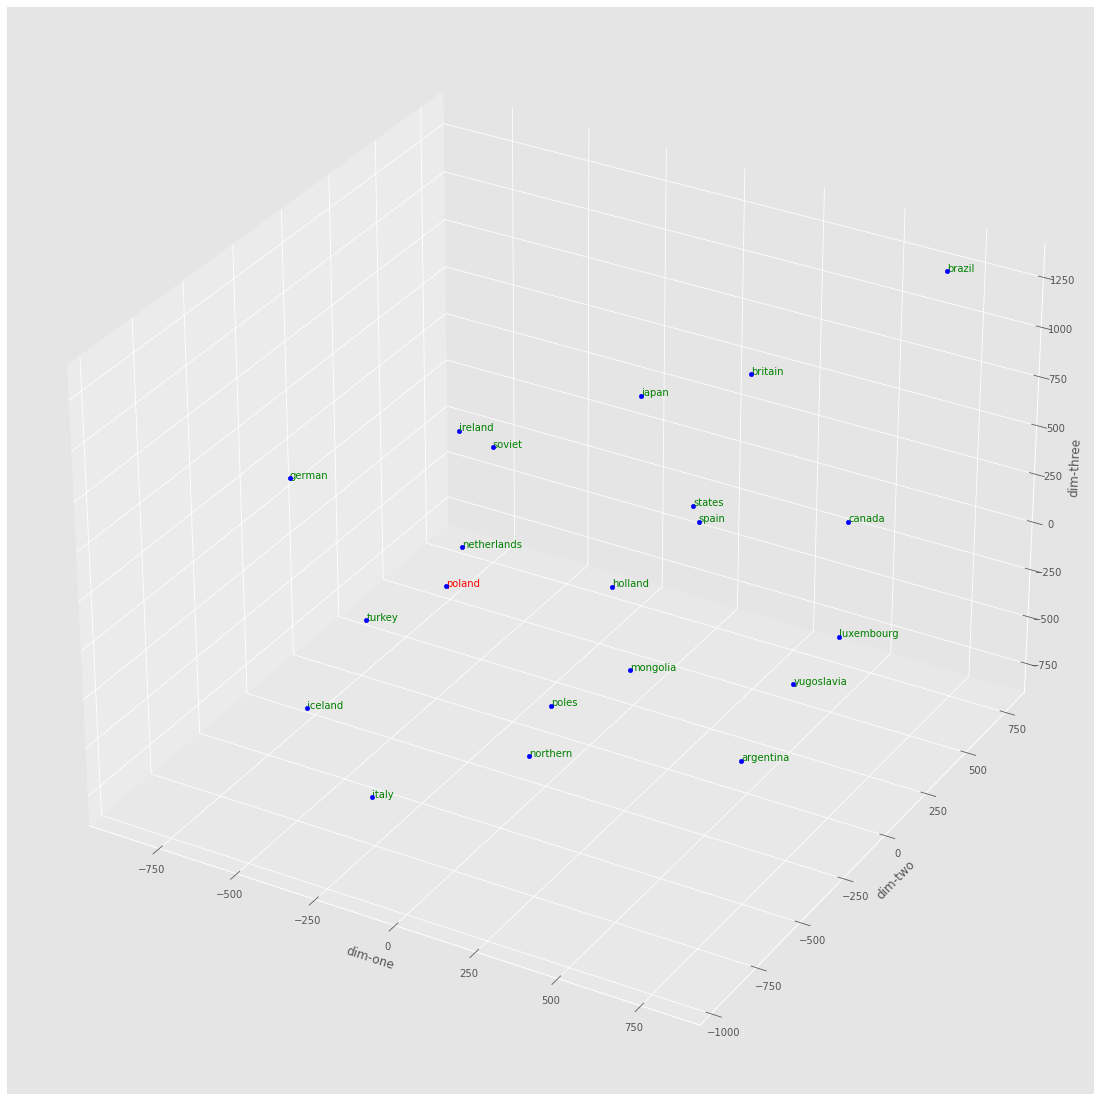

In [35]:
plot3D_with_labels(word='poland', k=20, model= my_best_rnn)

--- 
<div style="text-align: center"> <span style="color:green">GOOD LUCK WITH YOUR ASSIGNMENT 2!</span> </div>
<div style="text-align: center"> <span style="color:black">END OF ASSIGNMENT</span> </div>